In [9]:
# Setup
!pip install --quiet --upgrade pip

# Install the dependencies.
!pip install --quiet -r requirements_tf.txt

# Restart the runtime by ending the process.
exit()

In [1]:
import os
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = INFO, 2 = WARNING, 3 = ERROR
import numpy as np
import pandas as pd
import tensorflow as tf
from google.cloud import storage
import google.auth
from importlib import reload
from serving.constants import  BUCKET, IMG_SOURCE_PREFIX, HIST_DEST_PREFIX, NUM_BANDS, HIST_BINS_LIST, SCALE, CROP, MONTHS, IMAGE_BATCH, NUM_BINS
from serving.common import list_blobs_with_prefix
from serving.hist_training import create_hist_dataset, create_data_sample, get_labels, LstmModel, load_dataset_from_gcp, save_dataset_to_gcp
from serving.data import check_blob_prefix_exists, batch_check_blobs, get_varied_labels
import logging
import io
import itertools
from google.cloud import storage
import google.auth
import time

from keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import mlflow
import mlflow.keras
import matplotlib.pyplot as plt

In [2]:
# SETUP

#####
CREATE_DATASET = False
#####

start_time = time.perf_counter()
credentials, _ = google.auth.default()
bucket_name = BUCKET
directory_prefix = IMG_SOURCE_PREFIX
output_prefix = HIST_DEST_PREFIX
labels_data = "labels_combined.npy"
labels_header = "labels_header.npy"
batch_size = 32

client = storage.Client()
bucket = client.get_bucket(bucket_name)
num_bins = 128



# Create a directory for MLflow artifacts
mlflow_artifacts_dir = os.path.abspath('mlflow_artifacts')
os.makedirs(mlflow_artifacts_dir, exist_ok=True)

# Set MLflow tracking URI to the local directory
mlflow.set_tracking_uri(f"file:{mlflow_artifacts_dir}")         

In [3]:
file_name = f"{num_bins}_buckets_training_test" #"hist_dataset_medium" #
#dataset_suffix = r".tfrecords"

#file_name += dataset_suffix


if CREATE_DATASET:
    # Generate all prefixes
    start_time = time.perf_counter()
    
    labels_df = get_varied_labels(0,600)
    labels = list(zip(labels_df["county_name"],
                      labels_df["county_ansi"],
                 labels_df["state_ansi"],
                 labels_df["year"]))


    prefixes_hist = [f'histograms/{num_bins}_buckets/{SCALE}/{county.capitalize()}_{fips}/{year}' 
                for county,_, fips, year in labels]

    # Batch check all prefixes
    results_hist = batch_check_blobs(bucket_name, prefixes_hist)

    # Generate get_input_img_params based on results
    get_input_img_params = [(county.capitalize(), fips, year)
                for county, county_fips, fips, year in labels
                if results_hist[f'histograms/{num_bins}_buckets/{SCALE}/{county.capitalize()}_{fips}/{year}']
    ]

    print(f"Number of items to process: {len(get_input_img_params)}")
    
    end_time_dataset_info = time.perf_counter()
    print(f"Collecting dataset information: {end_time_dataset_info-start_time}")
    
    dataset, input_shape = create_hist_dataset(get_input_img_params, "labels_combined.npy", "labels_header.npy", num_bins=num_bins)
    end_time_dataset = time.perf_counter()
    
    print(f"Building dataset: {(end_time_dataset - end_time_dataset_info)/60:.02} minutes")
    
    # Save dataset
    save_dataset_to_gcp(dataset, file_name = file_name)
    print("Dataset created")
    CREATE_DATASET = False
else:
    dataset = load_dataset_from_gcp(file_name=file_name)
    for features, label in dataset.take(1):
        input_shape = tuple(features.shape)
        label_shape = label.shape
    print("Dataset loaded")

Dataset loaded


In [4]:
# Sample labels
label_data = np.load(labels_data, allow_pickle=True)
label_header = np.load(labels_header, allow_pickle=True)
label_df = pd.DataFrame(label_data, columns=label_header)
label_df[label_df["county_name"]=='Sutter'.upper()]

,commodity_desc,reference_period_desc,year,state_ansi,state_name,county_ansi,county_name,target,source_file
66,CORN,YEAR,2016,06,CALIFORNIA,101,SUTTER,264.1,USDA_Corn_County_2016.csv
3045,CORN,YEAR,2018,06,CALIFORNIA,101,SUTTER,210.0,USDA_Corn_County_2018.csv
4389,CORN,YEAR,2019,06,CALIFORNIA,101,SUTTER,147.1,USDA_Corn_County_2019.csv
7314,CORN,YEAR,2021,06,CALIFORNIA,101,SUTTER,169.9,USDA_Corn_County_2021.csv
8791,CORN,YEAR,2022,06,CALIFORNIA,101,SUTTER,133.8,USDA_Corn_County_2022.csv


146.14682
Epoch 1/5
92/92 [==============================] - 12s 120ms/step - loss: 17572.0508 - val_loss: 12101.3828
Epoch 2/5
92/92 [==============================] - 12s 126ms/step - loss: 9291.2607 - val_loss: 6445.5220
Epoch 3/5
92/92 [==============================] - 13s 138ms/step - loss: 4803.3008 - val_loss: 3466.7246
Epoch 4/5
92/92 [==============================] - 13s 142ms/step - loss: 2733.4297 - val_loss: 2322.0698
Epoch 5/5
92/92 [==============================] - 13s 135ms/step - loss: 1936.8724 - val_loss: 1629.1840


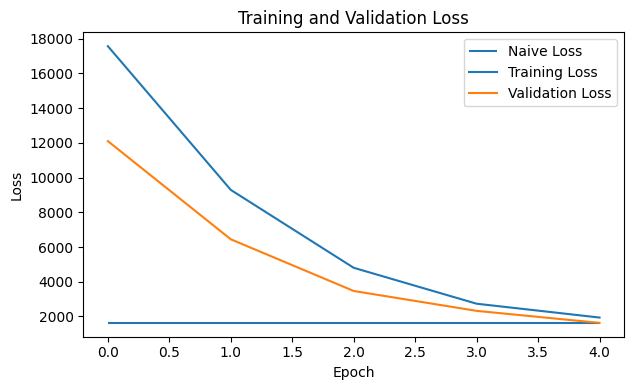

7/7 [==============================] - 1s 56ms/step - loss: 1720.1981


In [5]:
responses = []
for _, response in dataset:
    responses.append(response.numpy())
mean_response = np.mean(responses)
print(mean_response)

model = LstmModel(input_shape=input_shape, lstm_layers=4, no_units=2, mean_response=0)
model.compile(optimizer='nadam', learning_rate = 0.5)
history = model.fit(dataset, epochs=5, batch_size=batch_size)

In [7]:
model.summary()
print(model.naive_loss)

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 multiple                  13336     
                                                                 
 lstm_1 (LSTM)               multiple                  40        
                                                                 
 lstm_2 (LSTM)               multiple                  40        
                                                                 
 lstm_3 (LSTM)               multiple                  40        
                                                                 
 dense (Dense)               multiple                  3         
                                                                 
Total params: 13,459
Trainable params: 13,459
Non-trainable params: 0
_________________________________________________________________
1456.4299
